In [132]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel 
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder , OneHotEncoder, StandardScaler
from scipy.stats import chi2_contingency, chi2
sns.set_theme()

In [2]:
train = pd.read_csv("train.csv.zip")
test = pd.read_csv("test.csv.zip")

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024 ** 2 # just added 
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage(deep=True).sum() / 1024 ** 2
    percent = 100 * (start_mem - end_mem) / start_mem
    print('Mem. usage decreased from {:5.2f} Mb to {:5.2f} Mb ({:.1f}% reduction)'.format(start_mem, end_mem, percent))
    return df

In [4]:
train = reduce_mem_usage(df=train)
test = reduce_mem_usage(df=test)

Mem. usage decreased from 216.76 Mb to 141.86 Mb (34.6% reduction)
Mem. usage decreased from 216.02 Mb to 141.84 Mb (34.3% reduction)


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114321 entries, 0 to 114320
Columns: 133 entries, ID to v131
dtypes: float16(108), int32(1), int8(5), object(19)
memory usage: 41.1+ MB


In [6]:
train.head()

,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1,1.335938,8.726562,C,3.921875,7.914062,2.599609,3.177734,0.012939,...,8.000000,1.990234,0.035767,AU,1.803711,3.113281,2.023438,0,0.636230,2.857422
1,4,1,NaN,NaN,C,NaN,9.187500,NaN,NaN,2.300781,...,NaN,NaN,0.599121,AF,NaN,NaN,1.958008,0,NaN,NaN
2,5,1,0.943848,5.308594,C,4.410156,5.324219,3.980469,3.927734,0.019638,...,9.335938,2.478516,0.013451,AE,1.773438,3.921875,1.120117,2,0.883301,1.176758
3,6,1,0.797363,8.304688,C,4.226562,11.625000,2.097656,1.987305,0.171997,...,7.019531,1.812500,0.002268,CJ,1.415039,2.955078,1.991211,1,1.676758,1.034180
4,8,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Z,NaN,NaN,NaN,0,NaN,NaN


In [7]:
int_col = [col for col in train.columns if train[col].dtype in ["int32", "int8"] and col not in ["ID", "target"]]
obj_col = [col for col in train.columns if train[col].dtype == "O"]
float_col = [col for col in train.columns if col not in int_col + obj_col + ["ID", "target"]]

In [8]:
int_col

['v38', 'v62', 'v72', 'v129']

### Discrete features


In [9]:
# after analysing the discrete features i noticed that v38 = v72 - (v62 + v129), 
# so here we have a choice either we keep all those features and use it as it is,
# or we can drop either (v62, v72, v129) or v38, i will keep them as a preprocessing that has been done for us 
train[int_col].head()

,v38,v62,v72,v129
0,0,1,1,0
1,0,2,2,0
2,0,1,3,2
3,0,1,2,1
4,0,1,1,0


### Categorical features

In [10]:
# The first thing we can do analyzing a categorical features is to plot the distribution of each
# first this will help to give some insight about how the data is distributed (uniform distr / multinomial distr)
# or is there no variance eg: {A:99.90%, B:0.10%}
train[obj_col].head()

,v3,v22,v24,v30,v31,v47,v52,v56,v66,v71,v74,v75,v79,v91,v107,v110,v112,v113,v125
0,C,XDX,C,C,A,C,G,DI,C,F,B,D,E,A,E,B,O,NaN,AU
1,C,GUV,C,C,A,E,G,DY,A,F,B,D,D,B,B,A,U,G,AF
2,C,FQ,E,NaN,A,C,F,AS,A,B,B,B,E,G,C,B,S,NaN,AE
3,C,ACUE,D,C,B,C,H,BW,A,F,B,D,B,B,B,B,J,NaN,CJ
4,C,HIT,E,NaN,A,I,H,NaN,C,F,B,D,C,G,C,A,T,G,Z


In [11]:
low_card = []
high_card = []
for col in obj_col:
    if train[col].nunique() > 10:
        high_card.append(col)
    else:
        low_card.append(col)
print("cattegoriacl columns with low cardinality: ",low_card)
print("cattegoriacl columns with high cardinality: ",high_card)

cattegoriacl columns with low cardinality:  ['v3', 'v24', 'v30', 'v31', 'v47', 'v66', 'v71', 'v74', 'v75', 'v91', 'v107', 'v110']
cattegoriacl columns with high cardinality:  ['v22', 'v52', 'v56', 'v79', 'v112', 'v113', 'v125']


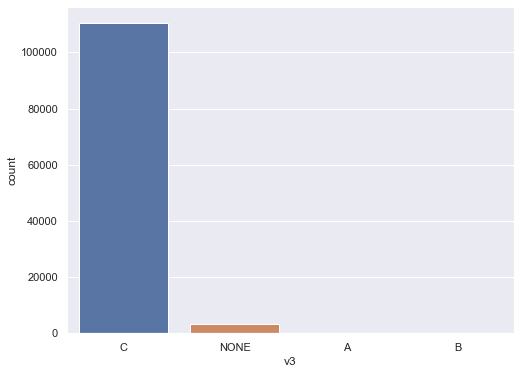

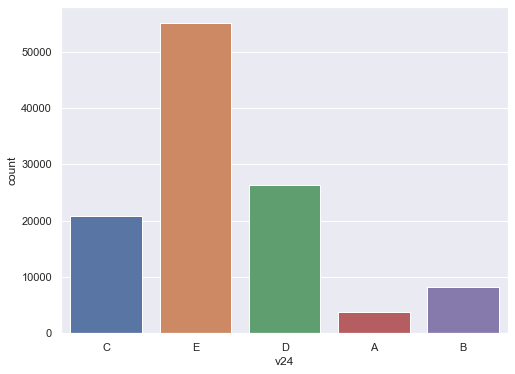

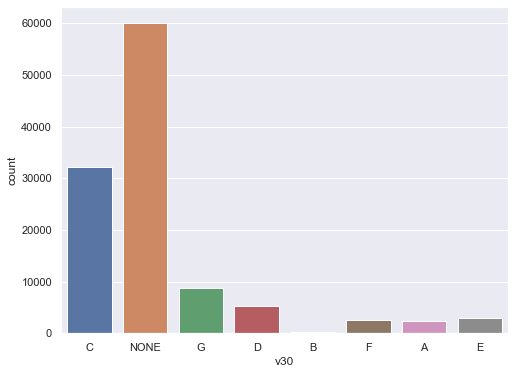

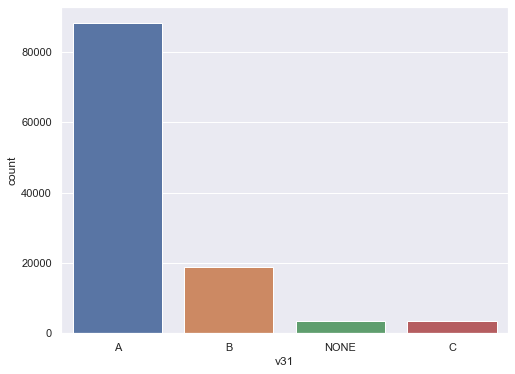

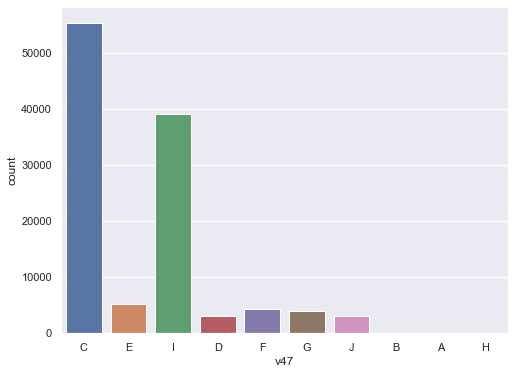

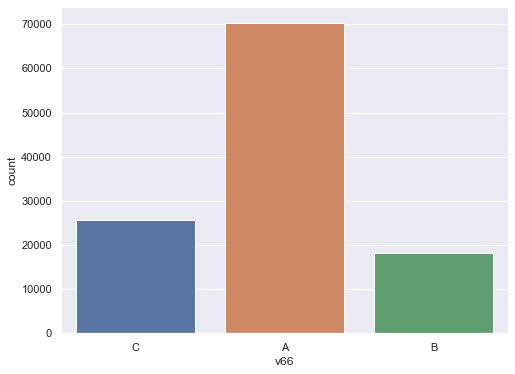

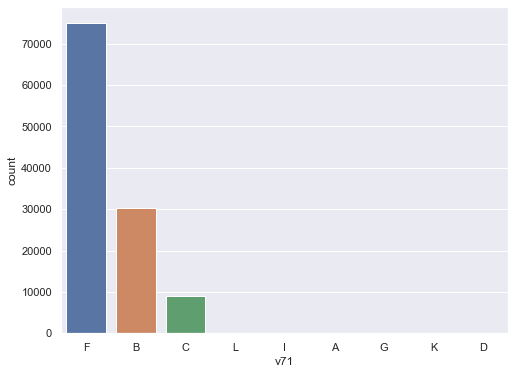

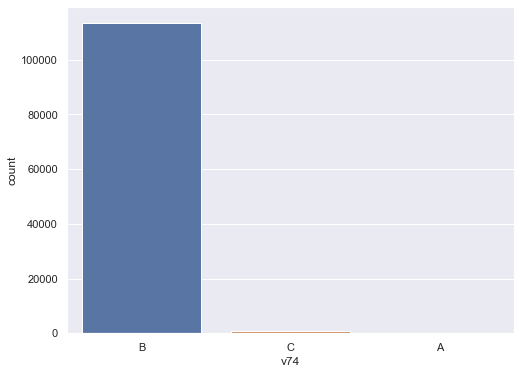

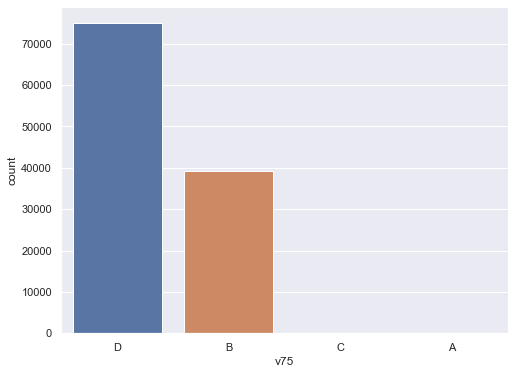

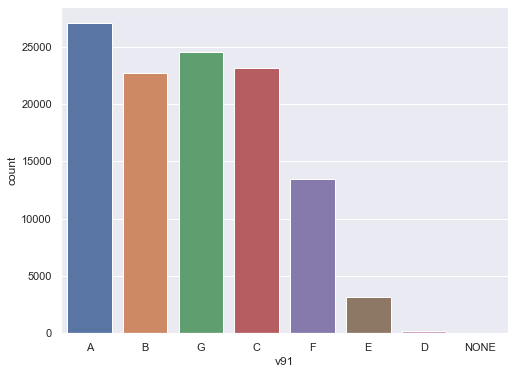

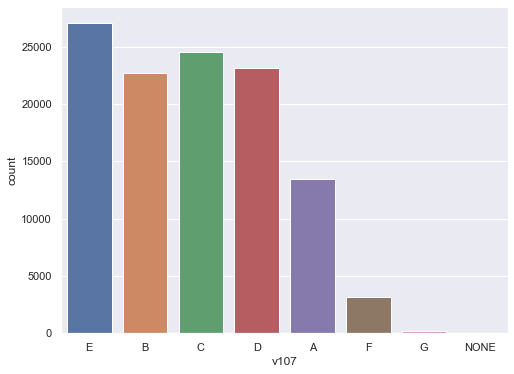

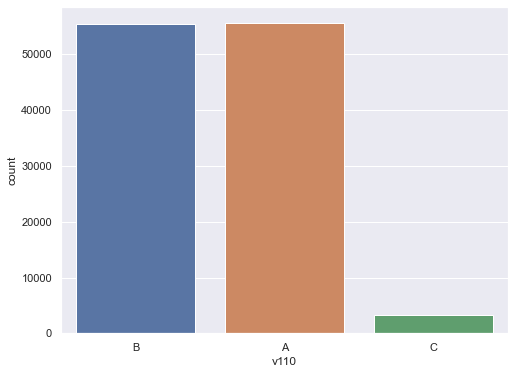

In [12]:
train[obj_col] = train[obj_col].fillna(value="NONE")
for col in low_card:
    plt.figure(figsize=(8,6))
    sns.countplot(x=col, data=train)

In [13]:
# as you can see from the distribution plot we have some similarity between (v91, v107) we can drop one of them.
# if we take a look at (v71, v75) dist(F) = dist(D) and dist(B+C) = dist(B) // we can merge them 
# also (v3, v31) dstribution of NONE are equal 
# there are some unbalanced features like (v74,v3)
# v52 nan ~ v91 nan ~ v107 nan
# v112 S ~ v125 AE
# v47 H ~ v56 AX
# looks like v22 is noise for it has too many different values 23419 values in 228714 samples
# v112 and v125 have similar distribution the difference is that v125 has high cardinality than v112
# same for v56 and v79
"""
for col in high_card:
    plt.figure(figsize=(8,6))
    sns.countplot(x=col, data=train)
    """

'\nfor col in high_card:\n    plt.figure(figsize=(8,6))\n    sns.countplot(x=col, data=train)\n    '

### numerical features



In [14]:
# First thing we can conclude from the table is that the "nan" value are not randomly missing and i suspect that there is 
# some information behind those "nan" some columns have the same number of missing values 
train[float_col].head()

,v1,v2,v4,v5,v6,v7,v8,v9,v10,v11,...,v120,v121,v122,v123,v124,v126,v127,v128,v130,v131
0,1.335938,8.726562,3.921875,7.914062,2.599609,3.177734,0.012939,10.000000,0.503418,16.437500,...,1.059570,0.803711,8.000000,1.990234,0.035767,1.803711,3.113281,2.023438,0.636230,2.857422
1,NaN,NaN,NaN,9.187500,NaN,NaN,2.300781,NaN,1.312500,NaN,...,NaN,NaN,NaN,NaN,0.599121,NaN,NaN,1.958008,NaN,NaN
2,0.943848,5.308594,4.410156,5.324219,3.980469,3.927734,0.019638,12.664062,0.765625,14.757812,...,2.138672,2.238281,9.335938,2.478516,0.013451,1.773438,3.921875,1.120117,0.883301,1.176758
3,0.797363,8.304688,4.226562,11.625000,2.097656,1.987305,0.171997,8.968750,6.542969,16.343750,...,1.166016,1.956055,7.019531,1.812500,0.002268,1.415039,2.955078,1.991211,1.676758,1.034180
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.050781,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,8.859375,NaN,NaN,0.360107,NaN,1.050781,NaN,...,NaN,NaN,NaN,NaN,0.049866,NaN,NaN,1.536133,NaN,NaN
6,0.899902,7.312500,3.494141,9.945312,1.925781,1.770508,0.066223,5.011719,2.341797,16.281250,...,0.846680,2.232422,3.476562,1.992188,0.083740,3.275391,1.623047,2.265625,2.263672,0.970703
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.837891,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2.078125,8.460938,3.738281,5.265625,1.573242,2.302734,0.015869,11.109375,4.464844,16.046875,...,1.414062,1.276367,8.148438,1.875977,0.018661,1.159180,5.582031,1.105469,1.170898,3.333984
9,1.144531,5.878906,3.244141,9.539062,2.500000,1.559570,0.412598,9.976562,2.363281,16.093750,...,0.434814,2.716797,7.324219,4.898438,0.008942,1.344727,1.601562,1.927734,3.173828,1.000000


<AxesSubplot:>

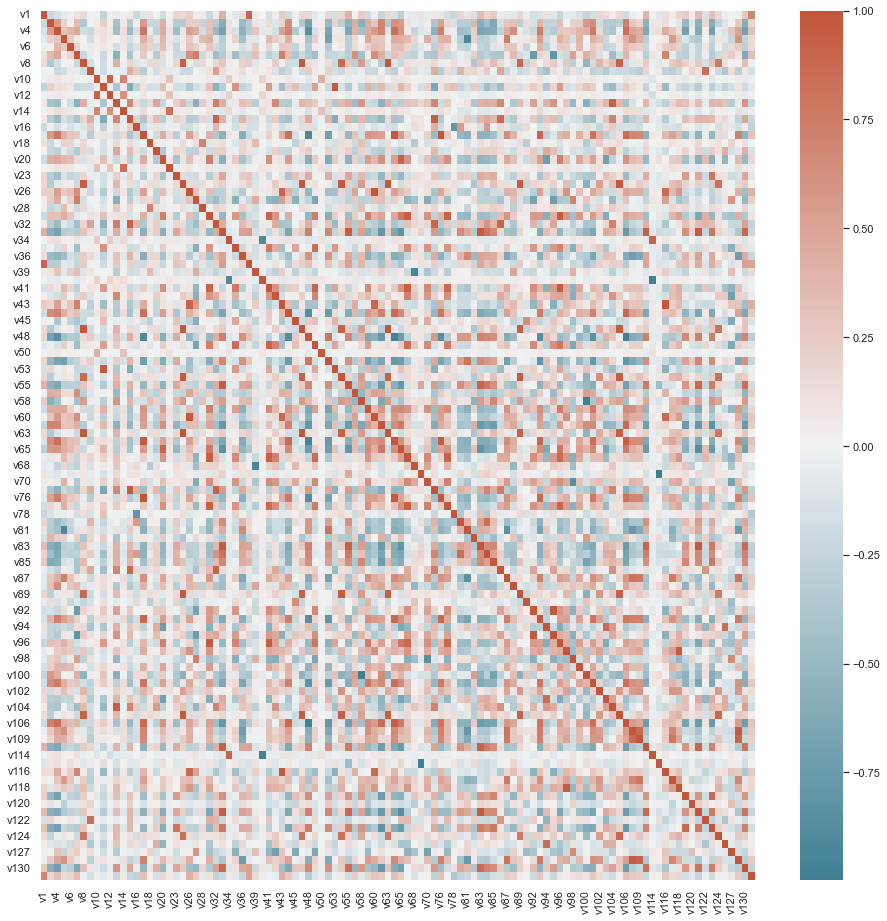

In [15]:
# after some a lot of plotting i found similarity between some features distribution and there are highly correlated corr > 0.9
# visualise correlated features:

# I will build a correlation matrix, which examines the 
# correlation of all features (that is, for all possible feature combinations)
# and then visualise the correlation matrix using a heatmap

# the default correlation method of pandas.corr is pearson
corrmat = train[float_col].corr(method='pearson')

# we can make a heatmap with the package seaborn
# and customise the colours of searborn's heatmap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# some more parameters for the figure
fig, ax = plt.subplots()
fig.set_size_inches(16,16)

# and now plot the correlation matrix
sns.heatmap(corrmat, cmap=cmap)

In [16]:
corrmat = train[float_col].corr()
corrmat = corrmat.abs().unstack() # absolute value of corr coef
corrmat = corrmat.sort_values(ascending=False)
corrmat = corrmat[corrmat >= 0.9]
corrmat = corrmat[corrmat < 1]
corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ['feature1', 'feature2', 'corr']
corrmat.head()

,feature1,feature2,corr
0,v58,v100,0.997665
1,v100,v58,0.997665
2,v115,v69,0.993692
3,v69,v115,0.993692
4,v76,v17,0.992672


In [17]:
# find groups of correlated features

grouped_feature_ls = []
correlated_groups = []

for feature in corrmat.feature1.unique():
    
    if feature not in grouped_feature_ls:

        # find all features correlated to a single feature
        correlated_block = corrmat[corrmat.feature1 == feature]
        grouped_feature_ls = grouped_feature_ls + list(
            correlated_block.feature2.unique()) + [feature]

        # append the block of features to the list
        correlated_groups.append(correlated_block)

print('found {} correlated groups'.format(len(correlated_groups)))
print('out of {} total features'.format(train[float_col].shape[1]))

found 22 correlated groups
out of 108 total features


In [18]:
# now we can print out each group. We see that some groups contain
# only 2 correlated features, some other groups present several features 
# that are correlated among themselves.

for group in correlated_groups:
    print(group)
    print()

  feature1 feature2      corr
0      v58     v100  0.997665

  feature1 feature2      corr
2     v115      v69  0.993692

   feature1 feature2      corr
4       v76      v17  0.992672
51      v76      v64  0.953865

   feature1 feature2      corr
6       v63      v46  0.991609
13      v63      v25  0.981051
23      v63       v8  0.975956
67      v63     v105  0.939527
77      v63      v89  0.930916
90      v63      v54  0.918711

   feature1 feature2      corr
14      v60      v26  0.980747

   feature1 feature2      corr
16     v106      v48  0.980726
70     v106      v64  0.933008

   feature1 feature2      corr
18     v116      v43  0.977873

   feature1 feature2     corr
20      v95      v92  0.97709

   feature1 feature2      corr
28     v114      v40  0.966913
99     v114      v34  0.912381

    feature1 feature2      corr
30       v83     v121  0.966239
34       v83      v33  0.964305
114      v83     v111  0.904088
124      v83      v55  0.901703

   feature1 feature2      corr

In [19]:
drop_columns = []
for i in range(len(correlated_groups)):
    groups = list(correlated_groups[i]["feature2"].unique()) + list(correlated_groups[i]["feature1"].unique())
    # train a random forest 
    rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
    rf.fit(train[groups].fillna(-9999), train["target"])
    
    # get the feature importance attributed by the 
    # random forest model 

    importance = pd.concat(
                           [pd.Series(groups),
                           pd.Series(rf.feature_importances_)], axis=1)

    importance.columns = ['feature', 'importance']

    # sort features by importance, most important first
    print(importance.sort_values(by='importance', ascending=False))
    importance = importance.sort_values(by='importance', ascending=False)
    drop_features = list(importance["feature"].values)
    print(drop_features[1:])
    drop_columns.extend(drop_features[1:])

drop_columns   

    

  feature  importance
1     v58    0.575573
0    v100    0.424427
['v100']
  feature  importance
0     v69    0.530644
1    v115    0.469356
['v115']
  feature  importance
0     v17    0.341181
1     v64    0.334160
2     v76    0.324658
['v64', 'v76']
  feature  importance
2      v8    0.207819
3    v105    0.162486
0     v46    0.146390
6     v63    0.136718
1     v25    0.123971
5     v54    0.112728
4     v89    0.109888
['v105', 'v46', 'v63', 'v25', 'v54', 'v89']
  feature  importance
1     v60    0.510596
0     v26    0.489404
['v26']
  feature  importance
0     v48    0.434511
1     v64    0.299625
2    v106    0.265864
['v64', 'v106']
  feature  importance
0     v43    0.534887
1    v116    0.465113
['v116']
  feature  importance
1     v95    0.505495
0     v92    0.494505
['v92']
  feature  importance
1     v34    0.442510
2    v114    0.285589
0     v40    0.271901
['v114', 'v40']
  feature  importance
3     v55    0.319571
1     v33    0.215451
4     v83    0.199877
0    v12

['v100',
 'v115',
 'v64',
 'v76',
 'v105',
 'v46',
 'v63',
 'v25',
 'v54',
 'v89',
 'v26',
 'v64',
 'v106',
 'v116',
 'v92',
 'v114',
 'v40',
 'v33',
 'v83',
 'v121',
 'v111',
 'v97',
 'v108',
 'v109',
 'v29',
 'v77',
 'v67',
 'v41',
 'v53',
 'v68',
 'v15',
 'v73',
 'v104',
 'v86',
 'v12',
 'v20',
 'v5',
 'v49']

In [20]:
len(drop_columns)
from xfeat import SelectNumerical

38

In [21]:
len(float_col)

108

In [236]:
data = train.copy()
data.head()

,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,...,v123,v124,v125,v126,v127,v128,v129,v130,v131,v22-2
0,3,1,1.335938,8.726562,C,3.921875,7.914062,2.599609,3.177734,0.012939,...,1.990234,0.035767,AU,1.803711,3.113281,2.023438,0,0.636230,2.857422,88
1,4,1,NaN,NaN,C,NaN,9.187500,NaN,NaN,2.300781,...,NaN,0.599121,AF,NaN,NaN,1.958008,0,NaN,NaN,71
2,5,1,0.943848,5.308594,C,4.410156,5.324219,3.980469,3.927734,0.019638,...,2.478516,0.013451,AE,1.773438,3.921875,1.120117,2,0.883301,1.176758,64
3,6,1,0.797363,8.304688,C,4.226562,11.625000,2.097656,1.987305,0.171997,...,1.812500,0.002268,CJ,1.415039,2.955078,1.991211,1,1.676758,1.034180,67
4,8,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Z,NaN,NaN,NaN,0,NaN,NaN,72


In [237]:
columns_to_drop = drop_columns + ["v107"]
data.drop(columns=columns_to_drop, inplace=True)

In [238]:
#data["v125+v112"] = data["v125"] + data["v112"]
data["v71+v75"] = data["v71"] + data["v75"]
data.drop(columns=["v71","v75"], inplace=True)

In [239]:
dis_col = [col for col in data.columns if data[col].dtype in ["int32", "int8"] and col not in ["ID", "target"]]
cat_col = [col for col in data.columns if data[col].dtype == "O"]
cont_col = [col for col in data.columns if col not in dis_col + cat_col + ["ID", "target"]]

In [240]:
data["kfold"] = -1
kf = StratifiedKFold(n_splits=5,shuffle= True,random_state=50)
for fold,(train_id,valid_id) in enumerate(kf.split(X = data, y = data["target"])):
    #print(len(train_id),len(valid_id))
    data.loc[valid_id,"kfold"] = fold

In [241]:
data["kfold"].value_counts()

0    22865
3    22864
4    22864
1    22864
2    22864
Name: kfold, dtype: int64

In [242]:
features = [col for col in data.columns if col not in ["ID","target","kfold"]]

In [243]:
feat = data.groupby("v91")["target"].agg("count")/len(train)
feat.to_dict()

{'A': 0.23686811696888585,
 'B': 0.1984149893720314,
 'C': 0.20256120922665127,
 'D': 0.0020118788324104933,
 'E': 0.028043841463948005,
 'F': 0.11737126162297391,
 'G': 0.21470246061528503,
 'NONE': 2.6241897814049913e-05}

In [244]:
dt = data.copy()

In [245]:
dt.head()

,ID,target,v1,v2,v3,v4,v6,v7,v8,v9,...,v125,v126,v127,v128,v129,v130,v131,v22-2,v71+v75,kfold
0,3,1,1.335938,8.726562,C,3.921875,2.599609,3.177734,0.012939,10.000000,...,AU,1.803711,3.113281,2.023438,0,0.636230,2.857422,88,FD,3
1,4,1,NaN,NaN,C,NaN,NaN,NaN,2.300781,NaN,...,AF,NaN,NaN,1.958008,0,NaN,NaN,71,FD,0
2,5,1,0.943848,5.308594,C,4.410156,3.980469,3.927734,0.019638,12.664062,...,AE,1.773438,3.921875,1.120117,2,0.883301,1.176758,64,BB,4
3,6,1,0.797363,8.304688,C,4.226562,2.097656,1.987305,0.171997,8.968750,...,CJ,1.415039,2.955078,1.991211,1,1.676758,1.034180,67,FD,0
4,8,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,Z,NaN,NaN,NaN,0,NaN,NaN,72,FD,1


In [246]:
feat = data.groupby("v91")["target"].agg("mean")
feat.to_dict()

{'A': 0.7616233982052513,
 'B': 0.7635233434730856,
 'C': 0.7639158785680356,
 'D': 0.8130434782608695,
 'E': 0.8296943231441049,
 'F': 0.7423610076017291,
 'G': 0.7568547565695661,
 'NONE': 1.0}

In [128]:
dt.fillna(value=-1,inplace=True)

In [129]:
dt.head()

,ID,target,v1,v2,v3,v4,v6,v7,v8,v9,...,v125,v126,v127,v128,v129,v130,v131,v22-2,v71+v75,kfold
0,4,1,-1.000000,-1.000000,0.75937,-1.000000,-1.000000,-1.000000,2.300781,-1.000000,...,0.801527,-1.000000,-1.000000,1.958008,0,-1.000000,-1.000000,71,0.761871,0
1,6,1,0.797363,8.304688,0.75937,4.226562,2.097656,1.987305,0.171997,8.968750,...,0.721739,1.415039,2.955078,1.991211,1,1.676758,1.034180,67,0.761871,0
2,28,0,-1.000000,-1.000000,0.75937,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,0.771765,-1.000000,-1.000000,-1.000000,0,-1.000000,-1.000000,81,0.761871,0
3,46,1,-1.000000,-1.000000,0.75937,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,0.761025,-1.000000,-1.000000,-1.000000,0,-1.000000,-1.000000,66,0.774203,0
4,62,1,1.146484,12.789062,0.75937,4.417969,1.858398,2.734375,0.094116,10.398438,...,0.778502,1.384766,3.583984,1.509766,1,1.191406,1.521484,65,0.774203,0


In [136]:
scores = [0.46177137486202136, 0.458034426714907, 0.4644486410331918, 0.45697680774702953, 0.4623125395560119]
np.array(scores).mean()

0.4607087579826324

In [223]:
ndt = train[['v10', 'v12', 'v14', 'v21', 'v22', 'v24', 'v30', 'v34', 'v40', 'v47',
       'v50', 'v52', 'v56', 'v62', 'v66', 'v79', 'v91', 'v112', 'v113',
       'v114', 'v125',"target"]].copy()

In [224]:
train["v22"].isnull().sum()

0

In [225]:
ndt.columns

Index(['v10', 'v12', 'v14', 'v21', 'v22', 'v24', 'v30', 'v34', 'v40', 'v47',
       'v50', 'v52', 'v56', 'v62', 'v66', 'v79', 'v91', 'v112', 'v113', 'v114',
       'v125', 'target'],
      dtype='object')

In [226]:
dis_col = [col for col in ndt.columns if ndt[col].dtype in ["int32", "int8"]]
cat_col = [col for col in ndt.columns if ndt[col].dtype == "O"]
cont_col = [col for col in ndt.columns if col not in dis_col + cat_col ]

In [227]:
ndt[cat_col].head()

,v22,v24,v30,v47,v52,v56,v66,v79,v91,v112,v113,v125
0,XDX,C,C,C,G,DI,C,E,A,O,NONE,AU
1,GUV,C,C,E,G,DY,A,D,B,U,G,AF
2,FQ,E,NONE,C,F,AS,A,E,G,S,NONE,AE
3,ACUE,D,C,C,H,BW,A,B,B,J,NONE,CJ
4,HIT,E,NONE,I,H,NONE,C,C,G,T,G,Z


In [228]:
ndt[cat_col].isnull().sum()

v22     0
v24     0
v30     0
v47     0
v52     0
v56     0
v66     0
v79     0
v91     0
v112    0
v113    0
v125    0
dtype: int64

In [229]:
ndt["kfold"] = -1
kf = StratifiedKFold(n_splits=5,shuffle= True,random_state=50)
for fold,(train_id,valid_id) in enumerate(kf.split(X = ndt, y = ndt["target"])):
    #print(len(train_id),len(valid_id))
    ndt.loc[valid_id,"kfold"] = fold

In [230]:
ndt[cat_col].isnull().sum()

v22     0
v24     0
v30     0
v47     0
v52     0
v56     0
v66     0
v79     0
v91     0
v112    0
v113    0
v125    0
dtype: int64

In [235]:
ndt["v22"].sample(10)

11546    0.000009
19895    0.000000
18308    0.000009
11933    0.000008
21483    0.000011
9608          NaN
6813     0.000009
4267     0.000009
5445     0.000009
3538     0.000010
Name: v22, dtype: float64

In [ ]:
for col in obj_col:
    lbe = LabelEncoder()
    data[col] = lbe.fit_transform(data[col])

In [ ]:
num_col = [col for col in train.columns if col not in obj_col+["ID","target"]]
data[num_col] = data[num_col].fillna(0)
scaler = StandardScaler()
scaler.fit(data[num_col])
data[num_col] = scaler.transform(data[num_col])
sel_ = SelectFromModel(LogisticRegression(C=0.1, penalty='l1', solver='liblinear'))
features = [col for col in data.columns if col not in ["ID","target"]]
sel_.fit(data[features], data["target"])
selected_feat = data[features].columns[sel_.get_support()]

In [ ]:
len(selected_feat)

In [48]:
tokeep = selected_feat

NameError: name 'selected_feat' is not defined

In [ ]:
todrop = list(set(features).difference(tokeep))
todrop

In [ ]:
"""features = [col for col in data.columns if col not in ["ID","target"]]
X = data[features]
y = train["target"]
sel = SelectFromModel(RandomForestClassifier())
sel.fit_transform(X,y)
sel.get_support()
selected_feat = data[features].columns[(sel.get_support())]
print(len(selected_feat))
print(selected_feat)

# and now let's plot the distribution of importances

pd.Series(sel.estimator_.feature_importances_.ravel()).hist(bins=20)
plt.xlabel('Feature importance')
plt.ylabel('Number of Features')
plt.show()"""

In [ ]:
data["target"].value_counts()

In [ ]:
def create_fold(data, num_fold, target):
    data["kfold"] = -1
    data = data.sample(frac=1).reset_index(drop=True)
    Kf = StratifiedKFold(n_splits=5, shuffle=False, random_state=None)
    for num_fold , (train_idx, val_idx) in enumerate(Kf.split(X=data,
                                                             y=data[target].values)):
        print(num_fold, len(train_idx), len(val_idx))
        data.loc[val_idx, "kfold"] = num_fold
    return data

In [ ]:
data = create_fold(data=data, num_fold=5, target="target")
data.head()

In [ ]:
for fold in range(5):
    plt.figure(figsize=(7,5))
    counts = data.loc[data["kfold"]==fold,"target"].value_counts()
    bar = sns.barplot(x=counts.index, y=counts.values)
    bar.set_title(f"barplot for fold {fold}")
    bar.set_xlabel("target", fontsize=20)
    bar.set_ylabel("count", fontsize=20)

In [ ]:
float_col = [col for col in num_col if data[col].dtype == "float16"]
print(float_col)

In [ ]:
"""
for col in float_col:
    data["flag_"+col] = np.where(data[col].isnull(),1,0)
"""

In [ ]:
"""
def run(fold, data):
    new_list = None
    dt_train = data[data["kfold"]!=fold].reset_index(drop=True)
    dt_valid = data[data["kfold"]==fold].reset_index(drop=True)
    

    x_train = dt_train.drop(columns=["ID","target"])
    y_train = dt_train["target"].values

    x_valid = dt_valid.drop(columns=["ID","target"])
    y_valid = dt_valid["target"].values

    imputer = SimpleImputer(strategy="median")
    imputer.fit(x_train[float_col])
    print(imputer.statistics_)
    new_list = list(zip(float_col,imputer.statistics_))
    for idx in new_list:
        col = idx[0]
        val = idx[1]
        x_train[col] = x_train[col].fillna(val)
        x_valid[col] = x_valid[col].fillna(val)
    
    ohe = OneHotEncoder(sparse=False, handle_unknown="ignore")
    x_train_ohe = ohe.fit_transform(x_train[obj_col])
    x_valid_ohe = ohe.transform(x_valid[obj_col])

    x_train_ohe = pd.DataFrame(x_train_ohe, columns=[f"ohe_{i}" for i in range(x_train_ohe.shape[1])])
    x_valid_ohe = pd.DataFrame(x_valid_ohe, columns=[f"ohe_{i}" for i in range(x_valid_ohe.shape[1])])

    x_train = pd.concat([x_train,x_train_ohe], axis=1)
    x_valid = pd.concat([x_valid,x_valid_ohe], axis=1)

    clf = LogisticRegression()
    clf.fit(x_train, y_train)
    preds = clf.predict_proba(x_valid)[:,1]
    loss = log_loss(y_valid, preds)
    print(f"Fold = {fold}, Loss = {loss}")
"""
    

In [ ]:


def run(fold, data):
    dt_train = data[data["kfold"]!=fold].reset_index(drop=True)
    dt_valid = data[data["kfold"]==fold].reset_index(drop=True)

    x_train = dt_train.drop(columns=["ID","target"]).values
    y_train = dt_train["target"].values

    x_valid = dt_valid.drop(columns=["ID","target"]).values
    y_valid = dt_valid["target"].values

    clf = RandomForestClassifier(n_estimators=150)
    clf.fit(x_train, y_train)
    preds = clf.predict_proba(x_valid)[:,1]
    loss = log_loss(y_valid, preds)
    print(f"Fold = {fold}, Loss = {loss}")


In [ ]:

for fold in range(5):
    run(fold=fold, data=data)


In [ ]:


"""
nestimators = 150 pretty good

Fold = 0, Loss = 0.47398592635178177
Fold = 1, Loss = 0.47624905877324325
Fold = 2, Loss = 0.47475190891516317
Fold = 3, Loss = 0.4745711870138748
Fold = 4, Loss = 0.47811801708004814
"""

"""
nestimators = 200 pretty good

Fold = 0, Loss = 0.47312945121406547
Fold = 1, Loss = 0.47490128446845603
Fold = 2, Loss = 0.4739686498891336
Fold = 3, Loss = 0.4712535043380731
Fold = 4, Loss = 0.47628298318788387
"""

In [ ]:
"""
withouttuning

Fold = 0, Loss = 0.47407275363255597
Fold = 1, Loss = 0.4788465590383579
Fold = 2, Loss = 0.47694495287554883
Fold = 3, Loss = 0.472730843813113
Fold = 4, Loss = 0.48340922409018783
"""

In [ ]:
"""
features = [col for col in data.columns if col not in ["ID","target"]]
X = data[features]
y = data["target"]
sel = SelectFromModel(RandomForestClassifier())
sel.fit_transform(X,y)
sel.get_support()
selected_feat = data[features].columns[(sel.get_support())]
print(len(selected_feat))
print(selected_feat)

# and now let's plot the distribution of importances

pd.Series(sel.estimator_.feature_importances_.ravel()).hist(bins=20)
plt.xlabel('Feature importance')
plt.ylabel('Number of Features')
plt.show()

"""

In [ ]:
"""
selected features with random forest 
['v10', 'v12', 'v14', 'v21', 'v22', 'v24', 'v30', 'v34', 'v40', 'v47',
       'v50', 'v52', 'v56', 'v62', 'v66', 'v79', 'v91', 'v107', 'v112', 'v113',
       'v114', 'v125']
"""
    

In [ ]:
"""
data_crosstab = pd.crosstab(train["v91"],
                            train["v107"],
                           margins=True, margins_name="Total")


# significance level
alpha = 0.05

# Calcualtion of Chisquare
chi_square = 0
rows = train["v91"].unique()
columns = train["v107"].unique()
for i in columns:
    for j in rows:
        O = data_crosstab[i][j]
        E = data_crosstab[i]['Total'] * data_crosstab['Total'][j] / data_crosstab['Total']['Total']
        chi_square += (O-E)**2/E

# The p-value approach
print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
p_value = 1 - chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1))
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
        
print("chisquare-score is:", chi_square, " and p value is:", p_value)
print(conclusion)
print("\n--------------------------------------------------------------------------------------")
print("\n--------------------------------------------------------------------------------------")
print("Approach 2: The critical value approach to hypothesis testing in the decision rule")
critical_value = chi2.ppf(1-alpha, (len(rows)-1)*(len(columns)-1))
conclusion = "Failed to reject the null hypothesis."
if chi_square > critical_value:
    conclusion = "Null Hypothesis is rejected."
        
print("chisquare-score is:", chi_square, " and critical value is:", critical_value)
print(conclusion)
"""